In [1]:
import numpy as np
from ito_diffusions.ito_diffusion_1d import FBM
from hurst_fitter import Hurst_fitter
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('dark_background')

In [2]:
T = 1.0
SCHEME_STEPS = int(252 * 4)
fitter = Hurst_fitter(n_lags=10)

In [3]:
spread = 2.0
H = 0.7
vol_bid = 1.0

Bid = FBM(x0=100, T=T, scheme_steps=SCHEME_STEPS, drift=0.0, vol=vol_bid, H=H)

In [4]:
vol_mid = 1.5
gamma_h = lambda s, t: 0.5 * vol_bid ** 2 * (t ** (2 * H) + s ** (2 * H) - np.abs(t - s) ** (2 * H))
gamma_alpha = lambda s, t: (vol_mid ** 2 * np.min([s, t]) - gamma_h(s, t)) / spread ** 2

cov_alpha = np.zeros((Bid.scheme_steps + 1, Bid.scheme_steps + 1))
for i in range(Bid.scheme_steps + 1):
    cov_alpha[i][i] = gamma_alpha(i * Bid.scheme_step, i * Bid.scheme_step)
    for j in range(i):
        cov_alpha[i][j] = gamma_alpha(i * Bid.scheme_step, j * Bid.scheme_step)
        cov_alpha[j][i] = cov_alpha[i][j]

alpha = np.random.multivariate_normal(
    np.zeros((Bid.scheme_steps + 1,)) + 0.5,
    cov_alpha
    )

alpha = np.clip(alpha, 0.0, 1.0)

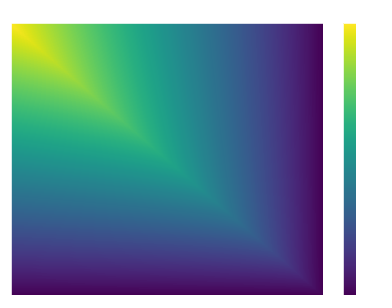

In [5]:
fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
im = ax.pcolormesh(cov_alpha[:, ::-1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Covariance matrix')
fig.colorbar(im, ax=ax)
plt.show()

/home/sauxpa/anaconda3/lib/python3.7/site-packages/hurst_fitter/main.py:50: RuntimeWarning: divide by zero encountered in power
  - 2 * np.abs(lag) ** (2 * H)
/home/sauxpa/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


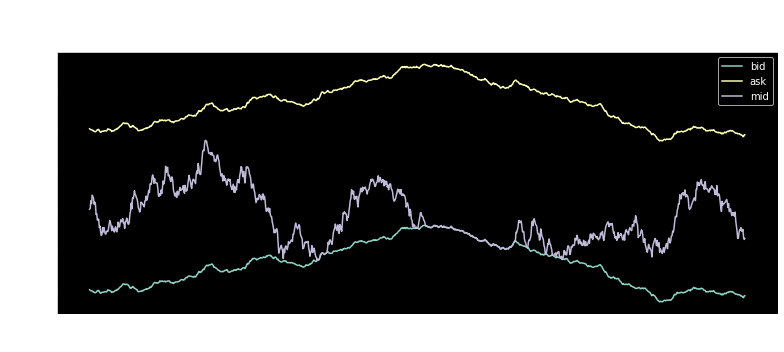

In [6]:
fig, ax = plt.subplots(figsize=(11, 5), nrows=1, ncols=1)
df = Bid.simulate()
df.rename(columns={'spot': 'bid'}, inplace=True)
df['ask'] = df['bid'] + spread
df['mid'] = df['bid'] + alpha * spread

fitter.df = df['bid']
H_bid = fitter.fit()
fitter.df = df['ask']
H_ask = fitter.fit()
fitter.df = df['mid']
H_mid = fitter.fit()

df.plot(kind='line', ax=ax)

ax.set_xlabel('time')
ax.set_ylabel('spot')
ax.legend()
ax.set_title('H_bid = {:.2f}\nH_ask = {:.2f}\nH_mid = {:.2f}'.format(H_bid, H_ask, H_mid))

plt.tight_layout()
plt.show()

fig.savefig('brownian_implied_mid.png', dpi=600)